In [5]:
# the bare minimum
import matplotlib.pyplot as plt  # for plotting
import geopandas as gpd  # for geospatial data handling
from matplotlib.lines import Line2D

# more advanced
from lonboard._map import Map
from lonboard._layer import PolygonLayer  # for mapping in 3D
from lonboard.colormap import (
    apply_categorical_cmap,
    apply_continuous_cmap,
)  # for assigning colors
from palettable.colorbrewer.sequential import PuRd_9  # for color palettes
from matplotlib.colors import LogNorm  # for logarithmic normalization
import pygwalker as pyg  # for creating interactive data visualizations

In [7]:
parcels = gpd.read_file("../Data/Parcels_(2024)/Parcels_(2024).shp")

In [8]:
parcels.head()

,OBJECTID,MAP_PAR_ID,LOC_ID,POLY_TYPE,MAP_NO,SOURCE,PLAN_ID,BND_CHK,NO_MATCH,TOWN_ID,last_edite,created_us,created_da,last_edi_1,ShapeSTAre,ShapeSTLen,geometry
0,1,0107062500,F_799998_2955292,FEE,1,ASSESS,None,None,N,35,2019-11-07,None,NaT,None,5.217380e+04,1420.659362,"POLYGON ((800251.826 2955616.543, 800115.183 2..."
1,2,0107069000,F_810842_2942136,FEE,1,ASSESS,None,None,N,35,2019-11-07,None,NaT,None,1.700132e+06,5663.985895,"POLYGON ((811495.739 2942096.043, 811509.717 2..."
2,3,0107073100,F_794811_2942749,FEE,1,ASSESS,None,None,N,35,2019-11-07,None,NaT,None,2.384763e+04,630.899280,"POLYGON ((794879.084 2942822.242, 794876.239 2..."
3,4,0107071000,F_794865_2944326,FEE,1,ASSESS,None,None,N,35,2019-11-07,None,NaT,None,2.042029e+06,6104.038098,"POLYGON ((795380.74 2945013.745, 795613.143 29..."
4,5,0107073000,F_795068_2942368,FEE,1,ASSESS,None,None,N,35,2019-11-07,None,NaT,None,5.066375e+05,2891.186046,"POLYGON ((795218.621 2941997.093, 795204.9 294..."


In [9]:
parcels.columns

Index(['OBJECTID', 'MAP_PAR_ID', 'LOC_ID', 'POLY_TYPE', 'MAP_NO', 'SOURCE',
       'PLAN_ID', 'BND_CHK', 'NO_MATCH', 'TOWN_ID', 'last_edite', 'created_us',
       'created_da', 'last_edi_1', 'ShapeSTAre', 'ShapeSTLen', 'geometry'],
      dtype='object')

In [10]:
list(parcels.dtypes)

[dtype('int32'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int32'),
 dtype('<M8[ms]'),
 dtype('O'),
 dtype('<M8[ms]'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),

In [11]:
land_use_columns = [col for col in parcels.columns if any(keyword in col.upper() for keyword in ['USE', 'LAND', 'ZONE', 'TYPE'])]
print("Land use related columns:", land_use_columns)

Land use related columns: ['POLY_TYPE']


In [12]:
if 'LAND_USE' in parcels.columns:
    use_column = 'LAND_USE'
elif 'USE_CODE' in parcels.columns:
    use_column = 'USE_CODE'
elif 'LU' in parcels.columns:
    use_column = 'LU'
else:
    use_column = land_use_columns[0] if land_use_columns else 'ZONE'

print(f"Using column: {use_column}")
parcels[use_column].value_counts()

Using column: POLY_TYPE


POLY_TYPE
FEE         98548
ROW           233
PRIV_ROW       61
RAIL_ROW        2
WATER           1
Name: count, dtype: int64

In [13]:
boston_land_use_codes = {
    "R1": "Single Family Residential",
    "R2": "Two Family Residential", 
    "R3": "Three Family Residential",
    "R4": "Multi-Family Residential",
    "A": "Apartments",
    "CD": "Commercial/Downtown",
    "CL": "Commercial/Local",
    "CM": "Commercial/Mixed",
    "I": "Industrial",
    "E": "Exempt (Government/Non-profit)",
    "RC": "Residential Condo",
    "CC": "Commercial Condo",
    "CP": "Condo Parking",
    "102": "Single Family",
    "103": "Condo",
    "104": "Two Family",
    "105": "Three Family",
    "111": "Apartment 4-6 Units",
    "112": "Apartment 7+ Units",
    "300": "Vacant Land",
    "336": "Parking Lot",
    "390": "Other Commercial",
    "400": "Industrial",
    "500": "Exempt Property"
}

In [14]:
print("Unique values in use column:", parcels[use_column].unique())

Unique values in use column: ['FEE' 'PRIV_ROW' 'ROW' 'WATER' 'RAIL_ROW']


In [15]:
print("Unique values in use column:", parcels[use_column].unique())


Unique values in use column: ['FEE' 'PRIV_ROW' 'ROW' 'WATER' 'RAIL_ROW']


In [16]:
def categorize_boston_land_use(code):
    """Categorize Boston land use codes into broader categories"""
    if pd.isna(code):
        return "Unknown"
    
    code_str = str(code).upper()
    
    if any(x in code_str for x in ['R1', 'R2', 'R3', 'SINGLE', 'TWO', 'THREE', '102', '104', '105']):
        return "Single/Multi-Family Residential"
    elif any(x in code_str for x in ['R4', 'A', 'APT', 'APARTMENT', '111', '112']):
        return "Apartment Buildings"
    elif any(x in code_str for x in ['RC', 'CONDO', '103']):
        return "Residential Condos"
    elif any(x in code_str for x in ['CD', 'CL', 'CM', 'COMMERCIAL', 'RETAIL', '390']):
        return "Commercial"
    elif any(x in code_str for x in ['I', 'INDUSTRIAL', 'MANUFACTURING', '400']):
        return "Industrial"
    elif any(x in code_str for x in ['E', 'EXEMPT', 'GOVERNMENT', 'MUNICIPAL', '500']):
        return "Exempt/Government"
    elif any(x in code_str for x in ['VACANT', 'LAND', '300']):
        return "Vacant Land"
    elif any(x in code_str for x in ['PARKING', 'GARAGE', '336']):
        return "Parking"
    else:
        return "Other"

import pandas as pd

# Apply the categorization
parcels['LandUse'] = parcels[use_column].apply(categorize_boston_land_use)

In [17]:
parcels.LandUse.value_counts()

LandUse
Exempt/Government      98548
Other                    233
Industrial                61
Apartment Buildings        3
Name: count, dtype: int64

In [19]:
area_columns = [col for col in parcels.columns if any(keyword in col.upper() for keyword in ['AREA', 'ACRES', 'SQFT', 'SIZE'])]
print("Area-related columns:", area_columns)

if area_columns:
    area_col = area_columns[0]
else:
    parcels['LotArea'] = parcels.geometry.area
    area_col = 'LotArea'

parcels.groupby("LandUse")[area_col].sum().sort_values(ascending=False)


Area-related columns: []


LandUse
Exempt/Government      1.241413e+09
Other                  2.127081e+08
Apartment Buildings    5.402632e+05
Industrial             2.501651e+05
Name: LotArea, dtype: float64

In [20]:
# Find additional numeric columns for analysis
numeric_columns = parcels.select_dtypes(include=['int64', 'float64']).columns
print("Numeric columns available:", list(numeric_columns))

Numeric columns available: ['ShapeSTAre', 'ShapeSTLen', 'LotArea']


In [21]:
agg_dict = {area_col: "sum"}

# Add other interesting columns if they exist
if 'GROSS_AREA' in parcels.columns:
    agg_dict['GROSS_AREA'] = "mean"
elif 'BUILDING_AREA' in parcels.columns:
    agg_dict['BUILDING_AREA'] = "mean"
elif 'BLDG_AREA' in parcels.columns:
    agg_dict['BLDG_AREA'] = "mean"

if 'TOTAL_VALUE' in parcels.columns:
    agg_dict['TOTAL_VALUE'] = "mean"
elif 'ASSESSED_VALUE' in parcels.columns:
    agg_dict['ASSESSED_VALUE'] = "mean"

landuse_summary = (
    parcels.groupby("LandUse")
    .agg(agg_dict)
    .reset_index()
)
landuse_summary

,LandUse,LotArea
0,Apartment Buildings,5.402632e+05
1,Exempt/Government,1.241413e+09
2,Industrial,2.501651e+05
3,Other,2.127081e+08


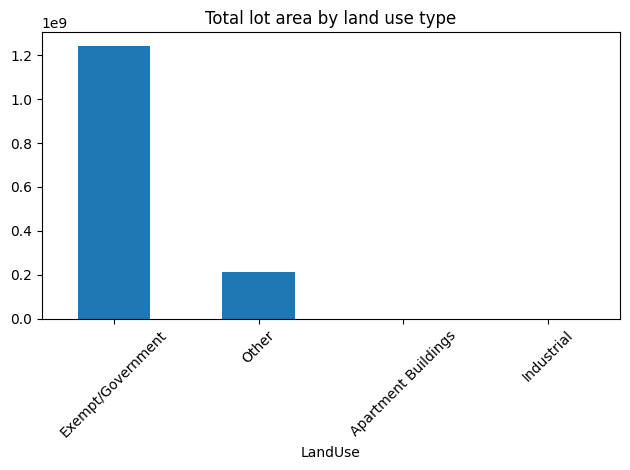

In [22]:
parcels.groupby("LandUse")[area_col].sum().sort_values(ascending=False).plot.bar()
plt.title("Total lot area by land use type")
plt.xticks(rotation=45)
plt.tight_layout()

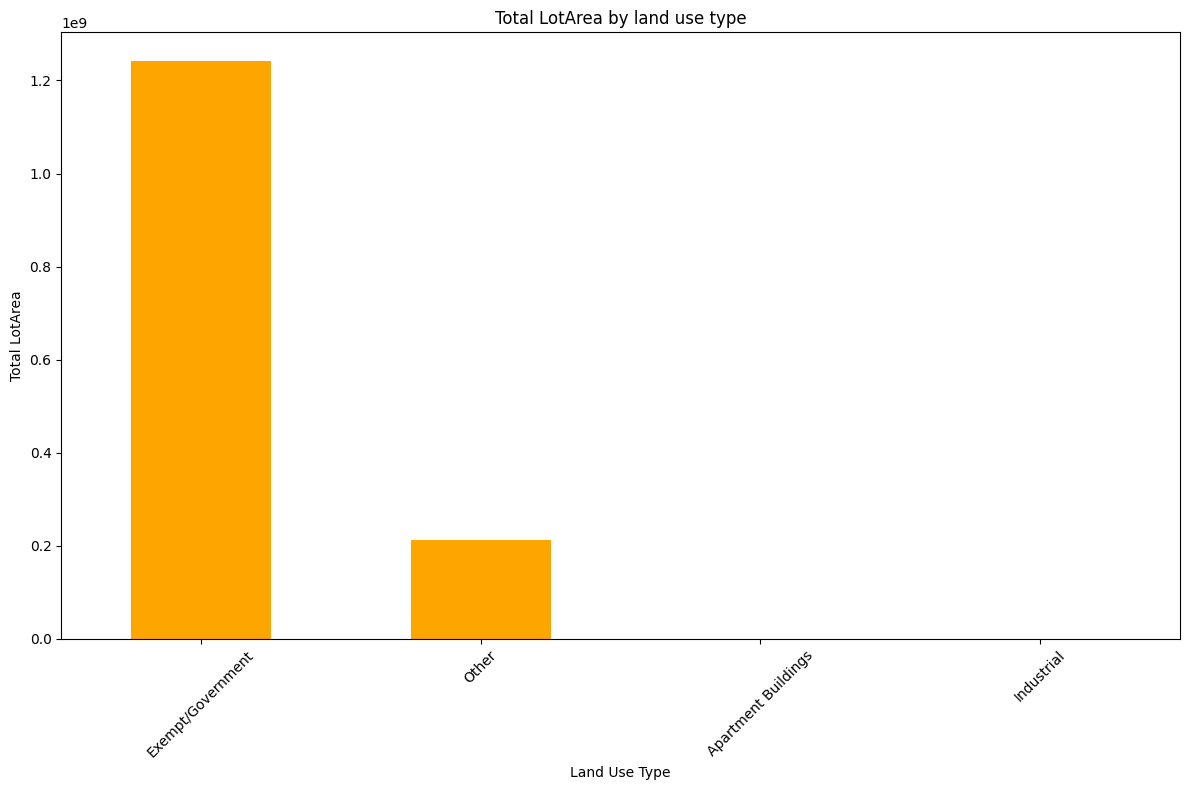

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
by_lot_area = parcels.groupby("LandUse")[area_col].sum().sort_values(ascending=False)

by_lot_area.plot.bar(ax=ax, color="orange")

ax.set_ylabel(f"Total {area_col}")
ax.set_xlabel("Land Use Type")
ax.tick_params(axis='x', rotation=45)

# Add a second variable if available
if len(agg_dict) > 1:
    ax2 = ax.twinx()
    second_col = list(agg_dict.keys())[1]
    parcels.groupby("LandUse")[second_col].sum().reindex(by_lot_area.index).plot.bar(
        ax=ax2, edgecolor="black", color="none"
    )
    ax2.set_ylabel(f"Total {second_col}")
    
    plt.title(f"Total {area_col} and {second_col} by land use type")
    
    # add legends
    ax.legend([area_col], loc="upper left")
    ax2.legend([second_col], loc="upper right")
else:
    plt.title(f"Total {area_col} by land use type")

plt.tight_layout()
plt.show()

In [24]:
numeric_cols = parcels.select_dtypes(include=['int64', 'float64']).columns
print("Available numeric columns:", list(numeric_cols))

# Use a relevant numeric column - could be floors, year built, assessed value, etc.
if 'NUM_FLOORS' in parcels.columns:
    floors_col = 'NUM_FLOORS'
elif 'FLOORS' in parcels.columns:
    floors_col = 'FLOORS'
elif 'STORIES' in parcels.columns:
    floors_col = 'STORIES'
elif 'YR_BUILT' in parcels.columns:
    floors_col = 'YR_BUILT'
elif 'YEAR_BUILT' in parcels.columns:
    floors_col = 'YEAR_BUILT'
else:
    # Use the first numeric column that's not area or value
    floors_col = [col for col in numeric_cols if not any(x in col.upper() for x in ['AREA', 'VALUE', 'PRICE', 'COST'])][0]

print(f"Using numeric column: {floors_col}")


Available numeric columns: ['ShapeSTAre', 'ShapeSTLen', 'LotArea']
Using numeric column: ShapeSTAre


In [25]:
parcels[floors_col].describe()

count    9.884500e+04
mean     1.471912e+04
std      3.165883e+05
min      5.398745e+00
25%      2.585013e+03
50%      4.292323e+03
75%      6.169359e+03
max      8.682431e+07
Name: ShapeSTAre, dtype: float64

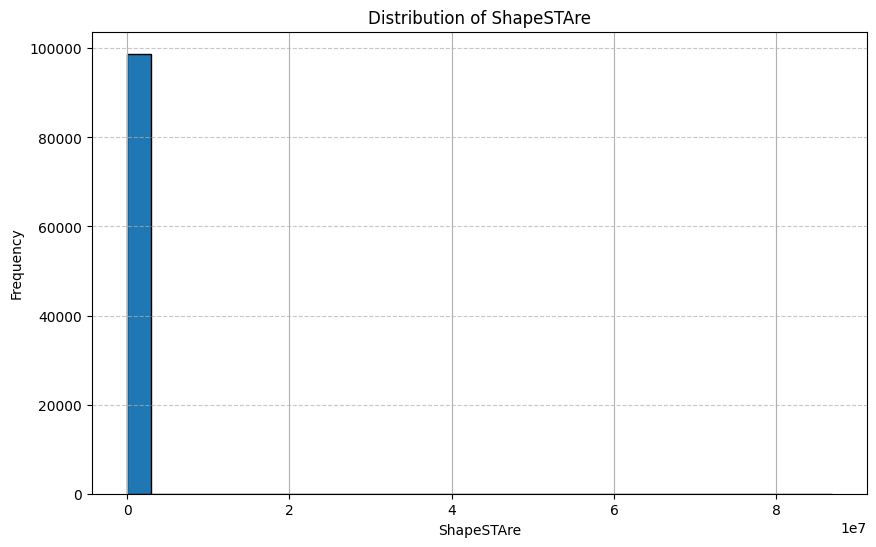

In [26]:
plt.figure(figsize=(10, 6))
parcels[floors_col].hist(bins=30, edgecolor="black")
plt.title(f"Distribution of {floors_col}")
plt.xlabel(floors_col)
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [27]:
parcels_non_spatial = parcels.drop(columns=["geometry"])

In [28]:
pyg.walk(parcels_non_spatial)

Box(children=(HTML(value='\n<div id="ifr-pyg-000639b6db39106bjfC8WMKlPdREcmHO" style="height: auto">\n    <hea…

Text(0.5, 1.0, 'Boston Parcels 2024')

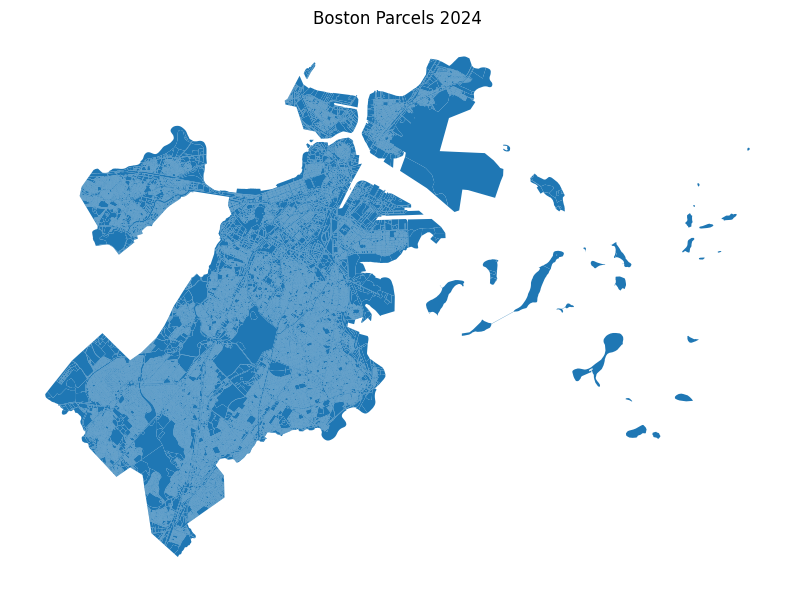

In [29]:
parcels.plot(figsize=(10, 10)).set_axis_off()
plt.title("Boston Parcels 2024")

In [30]:
boston_cmap = {
    "Single/Multi-Family Residential": "#ffff99",
    "Apartment Buildings": "#ffcc99", 
    "Residential Condos": "#ff9999",
    "Commercial": "#ff6666",
    "Industrial": "#9999ff",
    "Exempt/Government": "#66ccff",
    "Vacant Land": "#99ff99",
    "Parking": "#cccccc",
    "Other": "#666666",
    "Unknown": "#000000",
}

In [31]:
parcels.fillna({"LandUse": "Unknown"}, inplace=True)

In [32]:
parcels.LandUse.unique()

array(['Exempt/Government', 'Industrial', 'Other', 'Apartment Buildings'],
      dtype=object)

In [33]:
parcels["color"] = parcels["LandUse"].map(boston_cmap)

In [34]:
unmapped = parcels[parcels["color"].isna()]["LandUse"].unique()
if len(unmapped) > 0:
    print("Unmapped land use types:", unmapped)
    # Set unmapped values to a default color
    parcels["color"] = parcels["color"].fillna("#000000")

parcels["color"].unique()

array(['#66ccff', '#9999ff', '#666666', '#ffcc99'], dtype=object)

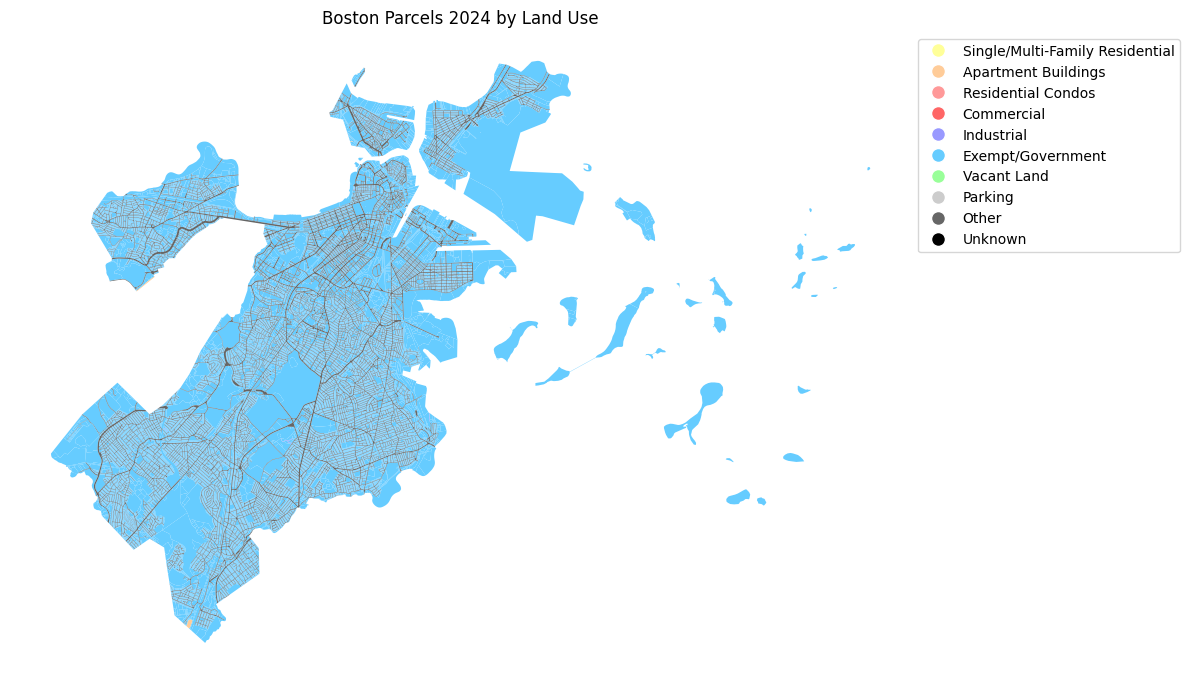

In [47]:
unmapped = parcels[parcels["color"].isna()]["LandUse"].unique()
if len(unmapped) > 0:
    print("Unmapped land use types:", unmapped)
    # Set unmapped values to a default color
    parcels["color"] = parcels["color"].fillna("#000000")

parcels["color"].unique()

ax = parcels.plot(
    color=parcels["color"],
    figsize=(12, 10),
    legend=True,
)
ax.set_axis_off()
plt.title("Boston Parcels 2024 by Land Use")

legend_colors = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in boston_cmap.values()
]
labels = boston_cmap.keys()
plt.legend(legend_colors, labels, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

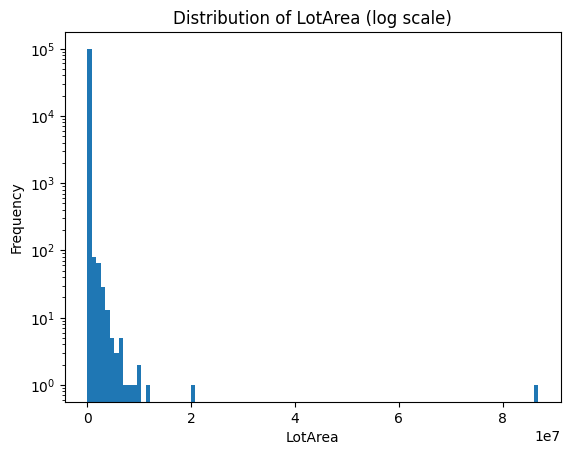

In [38]:
parcels[area_col].plot.hist(bins=100, log=True)
plt.title(f"Distribution of {area_col} (log scale)")
plt.xlabel(area_col)
plt.show()

In [39]:
parcels_wgs = parcels.to_crs("epsg:4326")

In [40]:
boston_cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in boston_cmap.items()}

boston_cmap_rgb

len(parcels_wgs[parcels_wgs["LandUse"].isna()])

parcels.fillna({"LandUse": "Unknown"}, inplace=True)

In [41]:
df = parcels_wgs[["LandUse", "geometry"]].copy()
df["LandUse"] = df["LandUse"].astype("category")

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(
        df["LandUse"],
        cmap=boston_cmap_rgb,
    ),
)
m = Map(layer)
m


Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7629c66afee0>
[
  [
    10…

In [42]:
df = parcels_wgs[[floors_col, "geometry"]].copy()

In [43]:
df = df.dropna(subset=[floors_col])
df = df[df[floors_col] > 0]

if len(df) > 0:
    normalizer = LogNorm(1, df[floors_col].max(), clip=True)
    normalized_values = normalizer(df[floors_col])
    
    layer = PolygonLayer.from_geopandas(
        df[[floors_col, "geometry"]],
        get_fill_color=apply_continuous_cmap(normalized_values, cmap=PuRd_9),
    )
    m = Map(layer)
    m

In [44]:
df = parcels_wgs[[floors_col, "geometry"]].copy()
df = df.dropna(subset=[floors_col])
df = df[df[floors_col] > 0]

if len(df) > 0:
    normalizer = LogNorm(1, df[floors_col].max(), clip=True)
    normalized_values = normalizer(df[floors_col])
    
    # Scale the elevation appropriately
    elevation_scale = 14 if 'FLOOR' in floors_col.upper() else 1
    
    layer = PolygonLayer.from_geopandas(
        df[[floors_col, "geometry"]],
        get_fill_color=apply_continuous_cmap(normalized_values, cmap=PuRd_9),
        extruded=True,
        get_elevation=df[floors_col] * elevation_scale,
    )
    m = Map(
        layer, view_state={"longitude": -71.06, "latitude": 42.36, "zoom": 10, "pitch": 45}
    )
    m

In [45]:
if 'YR_BUILT' in parcels.columns or 'YEAR_BUILT' in parcels.columns:
    year_col = 'YR_BUILT' if 'YR_BUILT' in parcels.columns else 'YEAR_BUILT'
    
    df = parcels_wgs[parcels_wgs[year_col] > 2010][[floors_col, "geometry"]].copy()
    df = df.dropna(subset=[floors_col])
    df = df[df[floors_col] > 0]
    
    if len(df) > 0:
        normalizer = LogNorm(1, df[floors_col].max(), clip=True)
        normalized_values = normalizer(df[floors_col])
        
        layer = PolygonLayer.from_geopandas(
            df[[floors_col, "geometry"]],
            get_fill_color=apply_continuous_cmap(normalized_values, cmap=PuRd_9),
            extruded=True,
            get_elevation=df[floors_col] * elevation_scale,
        )
        m = Map(layer)
        m